## Example Code of Protein Structure Analysis ![Python](https://img.shields.io/badge/Python-3.12-green.svg)

| **Title** | Unifying constraints linking protein folding and native dynamics decoded from AlphaFold |
| :--- | :--- |
| **Author** | Zecheng Zhang, Weitong Ren, Liangxu Xie, Yuxiang Zheng, Xingyue Guan, Jun Wang, Wenfei Li, and Qian-Yuan Tang* |
| **Email** | tangqy@hkbu.edu.hk |
| **Key Libraries** | `Biopython`, `numpy`, `mdtraj` |



<div class="alert alert-info">
  <b>Note:</b> This notebook requires Python 3.12 or higher.
</div>


# 1. Load Packages, and Calculate the indicators used in Letter

In [2]:
# Loading necessary packages 

import gzip
import numpy as np
from Bio.PDB import PDBParser

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def calculate_distance_matrix(calphas):
    """
    Computes pairwise Euclidean distances between Alpha-Carbon (CA) atoms.

    Args:
        calphas: List of Bio.PDB.Atom objects representing CA atoms.

    Returns:
        DistMat: Distance matrix between CA atoms
    """
    num_residues = len(calphas)
    DistMat = np.zeros((num_residues, num_residues))

    for i in range(num_residues):
        for j in range(num_residues):
            # Bio.PDB overloads subtraction to return Euclidean distance
            DistMat[i, j] = calphas[i] - calphas[j]

    return DistMat

def get_ca(structure):
    """
    Extracts all Alpha-Carbon (CA) atoms from the structure hierarchy.
    
    Iterates through all models and chains to flatten the structure into a list of CA atoms.
    """
    calphas = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if residue.has_id('CA'):
                    calphas.append(residue['CA'])
                
    return calphas


## 1.1  Contact Order (CO)

In [4]:
pdb_file = "AF-Q8L9G7-F1-model_v4.pdb.gz"
parser = PDBParser(QUIET=True)

# Parse PDB structure and extract CA coordinates
with gzip.open(pdb_file, "rt") as fh: 
    structure = parser.get_structure("Q8L9G7", fh)

calphas = get_ca(structure)
DistMat = calculate_distance_matrix(calphas)

# Contact Order calculation parameters
N = len(calphas)
co_ctf = 8.

def get_CO(DistMat, co_ctf: float = 8.0):
    """
    Calculates the Relative Contact Order (RCO) of a protein structure.

    RCO measures the average sequence separation of contacting residues, normalized by chain length.
    Contacts are defined as residues separated by >= 4 positions in sequence and < co_ctf in space.

    Args:
        DistMat: Pairwise distance matrix (N, N).
        co_ctf: Contact threshold distance (Angstroms).

    Returns:
        float: The relative contact order, rounded to 6 decimal places.
    """
    co_list = []
    N = DistMat.shape[0]

    # Iterate over residue pairs with sequence separation >= 4
    for i in range(4, N):
        for j in range(0, i - 4 + 1):
            if DistMat[i,j] < co_ctf:
                co_list.append((i-j))

    return round(np.mean(co_list) / N, 6)


CO = get_CO(DistMat, co_ctf = co_ctf)

print(f"the Contact Order is {CO}") 

the Contact Order is 0.150365


## 1.2  Fluctuation Entropy ($S$)

In [6]:
# pdb_file = "AF-Q8L9G7-F1-model_v4.pdb.gz"
s_ctf = 8.


def dist_to_laplacian(DistMat, s_ctf: float = 8.0):
    """
    Constructs the Kirchhoff matrix (Graph Laplacian) from the distance matrix.
    
    This represents the protein as an Elastic Network Model (ENM), where contacts 
    within 's_ctf' are modeled as springs.

    Args:
        DistMat: Pairwise distance matrix.
        s_ctf: Contact threshold distance (Angstroms).

    Returns:
        L: Laplacian matrix (D - A), often used as the Hessian in ENM.
    """
    # Create Adjacency Matrix: 1 if contact exists (dist <= s_ctf), else 0. Exclude self-loops.
    cMap = np.where((DistMat <= s_ctf) & (DistMat != 0), 1, 0)
    degrees = np.sum(cMap, axis=1)
    D = np.diag(degrees)
    L = D - cMap

    return L

def get_S(tmpHessian, first_n):
    """
    Calculates Fluctuation Entropy based on the spectral properties of the Hessian.

    Args:
        tmpHessian: The Laplacian/Hessian matrix.
        first_n: Number of low-frequency modes to include (excluding the trivial zero-mode).

    Returns:
        float: Negative sum of log-normalized eigenvalues for the top 'first_n' modes.
    """
    Eigs = np.linalg.eigvalsh(tmpHessian)
    Norm_eigs = Eigs/sum(Eigs) * float(len(Eigs))
    norm_eigen_list = np.log10(Norm_eigs[1:])
    norm_eigen_list_round = np.round(norm_eigen_list, 6)

    return -round(sum(norm_eigen_list_round[:first_n]),6)


tmpHessian = dist_to_laplacian(DistMat, s_ctf = s_ctf)
s = get_S(tmpHessian, first_n = 8)

print(f"the Fluctuation Entropy (S) is {s}")

the Fluctuation Entropy (S) is 10.698814


## 1.3 Visualization of Distance Map and Contact Map

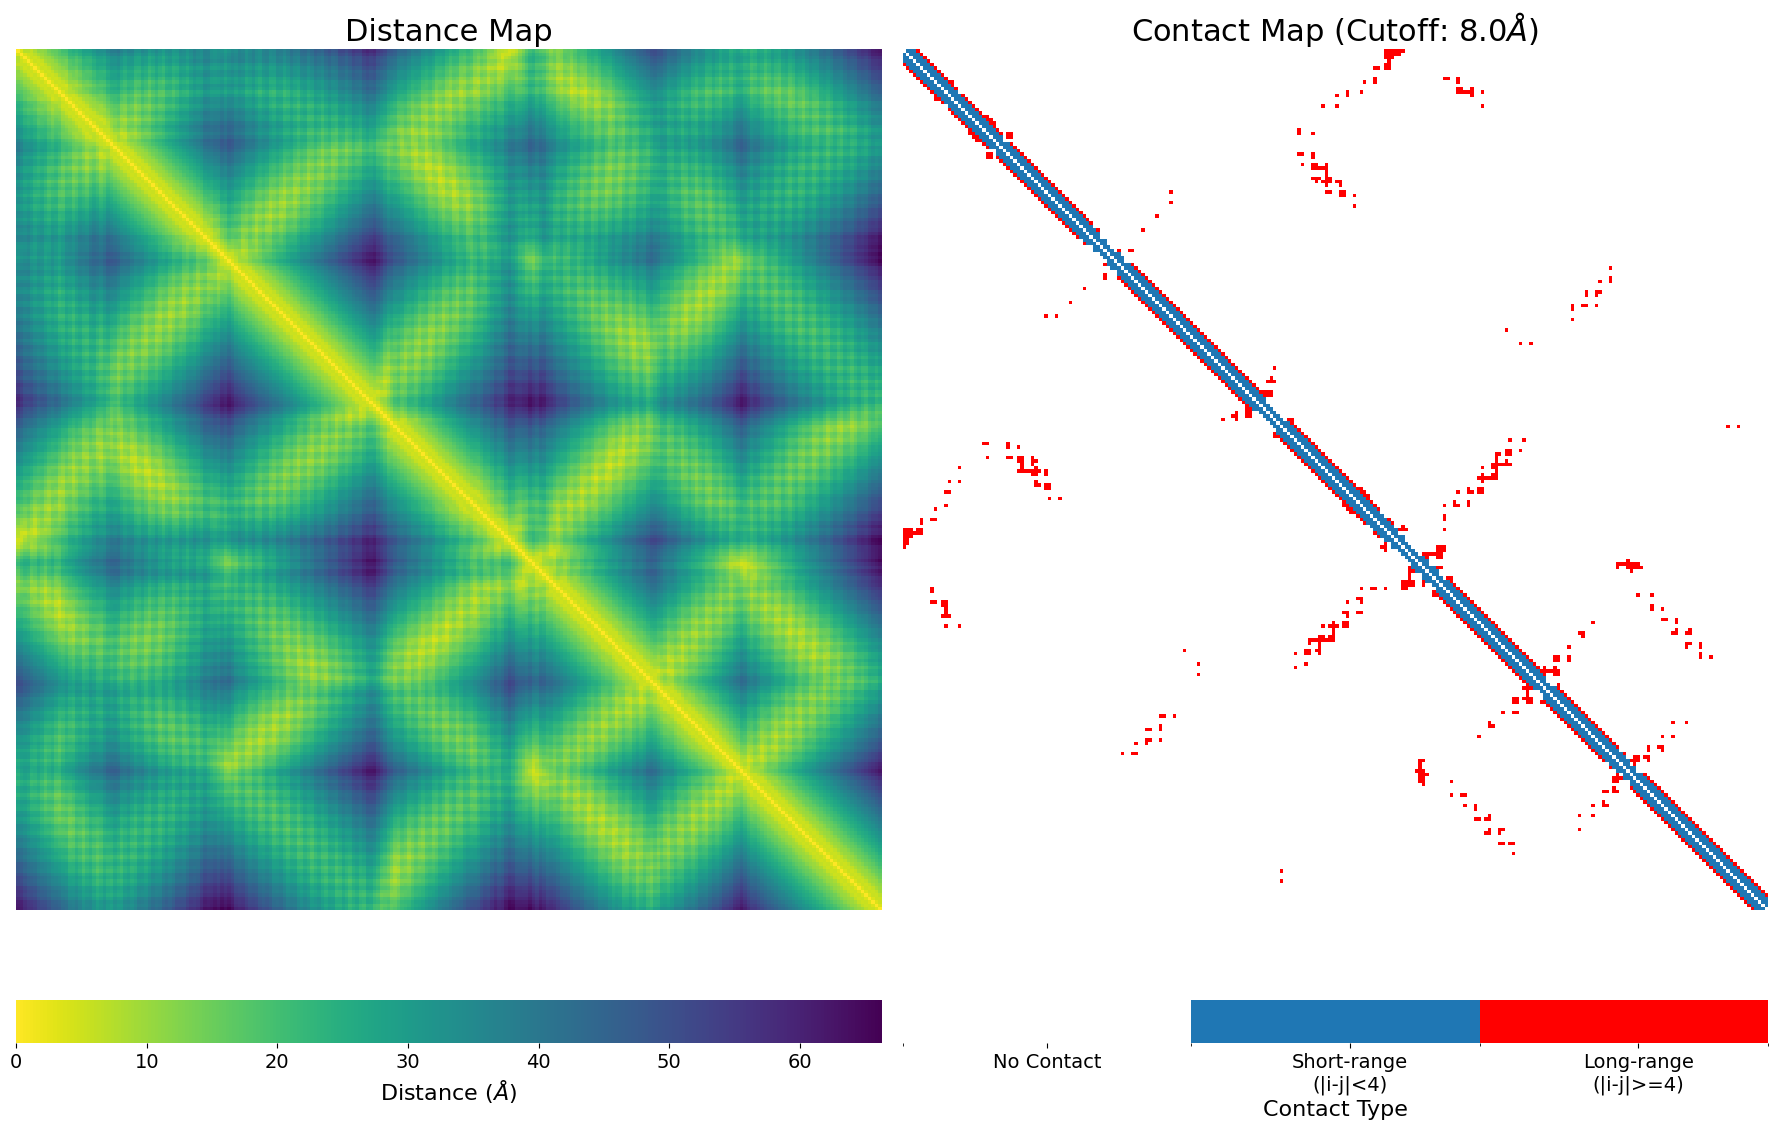

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import numpy as np

plt.rcParams.update({
    'font.size': 14, 
    'axes.titlesize': 22,   'axes.labelsize': 16,
    'xtick.labelsize': 14,  'ytick.labelsize': 14,
    'figure.titlesize': 24
})

cMap_shown = np.zeros((N, N))
contacts = (DistMat < 8.0)
indices = np.indices((N, N))
seq_sep = np.abs(indices[0] - indices[1])

cMap_shown[contacts] = 1 
cMap_shown[contacts & (seq_sep >= 4)] = 2
np.fill_diagonal(cMap_shown, 0)

# Example Figure (Left)
fig, axes = plt.subplots(1, 2, figsize=(18, 12))

sns.heatmap(DistMat, ax=axes[0], cmap='viridis_r', 
            xticklabels=False, yticklabels=False, 
            cbar_kws={'label': 'Distance ($\AA$)', 'orientation': 'horizontal', 'pad': 0.08})
axes[0].set_title('Distance Map')

cmap_custom = colors.ListedColormap(['#ffffff', '#1f77b4', '#ff0000'])
bounds = [0, 0.9, 1.9, 2.9]
norm = colors.BoundaryNorm(bounds, cmap_custom.N)

# Example Figure (Right)
sns.heatmap(cMap_shown, ax=axes[1], cmap=cmap_custom, norm=norm,
            xticklabels=False, yticklabels=False,
            cbar_kws={'ticks': [0.45, 1.45, 2.45], 'label': 'Contact Type', 'orientation': 'horizontal', 'pad': 0.08})

axes[1].set_title(f'Contact Map (Cutoff: {co_ctf}$\AA$)')

cbar = axes[1].collections[0].colorbar
cbar.ax.set_xticklabels(['No Contact', 'Short-range\n(|i-j|<4)', 'Long-range\n(|i-j|>=4)'])

plt.tight_layout()
plt.show()


# 2. Calculate the indicators used in the Supplementary Information

In [8]:
import networkx as nx
import mdtraj as md

from community import community_louvain
from networkx.algorithms.community.quality import modularity

## 2.1 Modularity ($Q$)

In [33]:
# pdb_file = "AF-Q8L9G7-F1-model_v4.pdb.gz"
# s_ctf = 8.
# tmpHessian = dist_to_laplacian(DistMat, s_ctf = s_ctf)

def get_Q(tmpHessian):
    """
    Constructs a graph from the Hessian and calculates its Modularity (Q).

    The function reconstructs the interaction network and runs the Louvain 
    community detection algorithm multiple times to ensure robustness.

    Args:
        tmpHessian: The Laplacian/Hessian matrix (N, N).

    Returns:
        float: The average modularity score over multiple runs.
    """
    
    
    N = tmpHessian.shape[0]

    # Initialize graph
    G = nx.Graph()
    G.add_nodes_from(range(N))

    # Reconstruct edges from the Hessian/Laplacian matrix
    rows, cols = np.where(tmpHessian < -0.9)

    # Avoid duplicate edges in undirected graph
    edges = zip(rows[rows < cols], cols[rows < cols])

    G.add_edges_from(edges)

    Q_list = []
    for _ in range(9):
        parti = community_louvain.best_partition(G)
        comms_map = {}
        for n, cid in parti.items():
            comms_map.setdefault(cid, set()).add(n)
        communities = list(comms_map.values())

        q = modularity(G, communities)
        # Alternative code: 
        # q = community_louvain.modularity(partition, G)
        
        Q_list.append(q)
    
    return np.mean(Q_list)

Q = get_Q(tmpHessian)
print(f"the Modularity is {round(Q, 6)}")

the Modularity is 0.700211


## 2.2 Fractal Dimension ($d_f$)

In [37]:
# Define range of cutoff distances (Angstroms)
rclist = np.array([5, 6, 7, 8, 9, 10, 11, 12])

def compute_fractal_dimension(DistMat, rclist):
    """
    Calculates the Fractal Dimension of the protein structure.

    Based on the power law relationship: N(r) ~ r^df
    where N(r) is the average number of neighbors within radius r.
    The exponent df is extracted from the slope of the log-log plot.

    Args:
        DistMat: Pairwise distance matrix.
        rclist: Array of cutoff distances to test.

    Returns:
        float: The fractal dimension (slope of the log-log fit).
    """
    N = DistMat.shape[0]
    avg_neighbors = []

    
    for rc in rclist:
        # OPTIMIZATION: Vectorized calculation
        # 1. (DistMat <= rc) creates a boolean matrix
        # 2. np.sum counts all True values (total contacts in the matrix)
        # 3. Divide by N to get the average number of neighbors per residue
        count = np.sum(DistMat <= rc)
        avg_neighbors.append(count / N)

    # Convert to log scale for linear fitting
    log_r = np.log(rclist)
    log_n = np.log(avg_neighbors)

    # Linear regression (1st degree polynomial)
    slope, _ = np.polyfit(log_r, log_n, 1)

    return round(slope, 6)

d_f = compute_fractal_dimension(DistMat, rclist)

print(f"the Fractal Dimension is {d_f}")

the Fractal Dimension is 2.178832


## 2.3 Solvent-Accessible Surface Area (SASA in unit $\AA ^2$)

In [ ]:
# pdb_file = "AF-Q8L9G7-F1-model_v4.pdb.gz"

# Calculate solvent-accessible surface area per residue
traj = md.load(pdb_file)
sasa = md.shrake_rupley(traj)
area = round(sum(sasa[0])*100.,6)
area_per_resi = round(area/float(N), 6)

print("the solvent-accessible surface area is {:.6f}".format(area_per_resi))

the solvent-accessible surface area is 56.418922


## 2.4 Radius of gyration ($R_g$ in unit $\AA$)

In [ ]:
# pdb_file = "AF-Q8L9G7-F1-model_v4.pdb.gz"
# traj = md.load(pdb_file)

rg = round(md.compute_rg(traj)[0]*10.,6)

print(f"the Radius of gyration is {rg}")

the Radius of gyration is 20.087515


## 2.5 coil fraction (coil%)

In [ ]:
# pdb_file = "AF-Q8L9G7-F1-model_v4.pdb.gz"
# traj = md.load(pdb_file)

dssp2 = md.compute_dssp(traj, simplified=True)[0]

frac_coil = str(dssp2).count('C') / len(dssp2)

print("the Coil fraction (based on simplifed DSSP) is ", round(frac_coil, 6))

the Coil fraction (based on simplifed DSSP) is  0.164


## 2.6 average predicted Local Distance Difference Test (\<pLDDT\>)

In [40]:
def get_b_factor(structure, chain_label = 'A'):
    """
    Extracts the average B-factor (or pLDDT for AlphaFold) per residue.
    
    Args:
        structure: Bio.PDB Structure object.

    Returns:
        np.array or dict
    """
    b_factor_dict = {}
    for model in structure:
        for chain in model:
            for residue in chain:
                res_id = residue.get_id()[1]  # residue id
                # calculate the average B-factor
                b_factors = [atom.get_bfactor() for atom in residue]
                avg_bfactor = np.mean(b_factors)
                b_factor_dict[f"{chain.id}_{res_id}"] = avg_bfactor

    return b_factor_dict

In [41]:
# pdb_file = "AF-Q8L9G7-F1-model_v4.pdb.gz"
# parser = PDBParser(QUIET=True)

# # Parse PDB structure and extract CA coordinates
# with gzip.open(pdb_file, "rt") as fh: 
#     structure = parser.get_structure("Q8L9G7", fh)

plddt_dict = get_b_factor(structure)
# for single chain (A)
plddt_mean = np.mean([value for key, value in plddt_dict.items() if key[0] == 'A'])

print('the average pLDDT is {:.6f}'.format(plddt_mean))

the average pLDDT is 94.604880
